In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt

/home/milab1070/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/milab1070/miniconda3/envs/seung/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
def spec_augment(feat, T = 30, F = 17, time_mask_num = 2, freq_mask_num = 2):

    
    feat_size = feat.shape[1]
    seq_len = feat.shape[2]

    # time mask
    for _ in range(time_mask_num):
        t = np.random.uniform(low=0.0, high=T)
        t = int(t)
        t0 = np.random.randint(0, seq_len - t)
        feat[t0 : t0 + t, :] = 0

    # freq mask
    for _ in range(freq_mask_num):
        f = np.random.uniform(low=0.0, high=F)
        f = int(f)
        f0 = np.random.randint(0, feat_size - f)
        feat[:, f0 : f0 + f] = 0

    return feat

In [ ]:
import copy
type(partition['train'][0][0])
b = copy.deepcopy(partition['train'][0][0])
max = len(partition['train'])
print(copy.deepcopy(partition['train'][0]))

(array([[[-1.6744331 , -1.6637099 , -1.6423854 , ..., -0.17723042,
         -0.3604153 , -0.4595727 ],
        [-1.254747  , -1.2215849 , -1.1558849 , ..., -0.835429  ,
         -0.5598216 , -0.66944003],
        [-0.25561696, -0.1969009 , -0.08188709, ...,  0.04262703,
         -0.20825617, -0.1889495 ],
        ...,
        [ 0.3435937 ,  0.12376004, -0.1721468 , ...,  0.19029285,
         -1.4754754 , -0.99427974],
        [ 0.4220042 ,  0.21937522, -0.05330383, ...,  0.46957824,
         -1.7613242 , -1.7081903 ],
        [ 0.51645833,  0.31554297,  0.05246185, ...,  0.6801062 ,
         -1.5461121 , -0.9023289 ]]], dtype=float32), 49)


In [ ]:
for index in range(max):
    img = partition['train'][index][0]
    label = partition['train'][index][1]
    
    copy_img = copy.deepcopy(img)
    copy_img = spec_augment(copy_img)
    aug_data = (copy_img, label)
    partition['train'].append(aug_data)

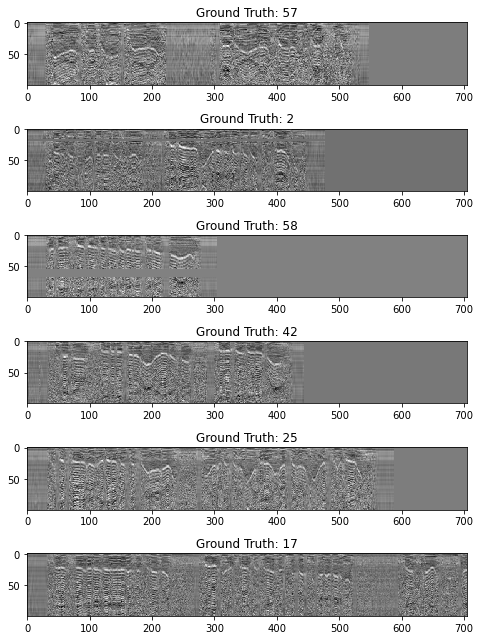

In [ ]:
train_loader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=8, 
                                              shuffle=True, num_workers=2)

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)  

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(6,1,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

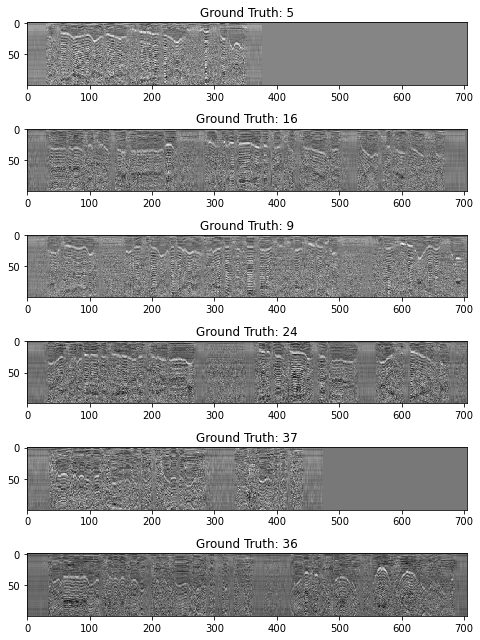

In [ ]:
val_loader = torch.utils.data.DataLoader(partition['val'], 
                                              batch_size=8, 
                                              shuffle=True, num_workers=2)

examples = enumerate(val_loader)
batch_idx, (example_data, example_targets) = next(examples)  

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(6,1,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

In [ ]:
import math


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        # SE
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_down = nn.Conv2d(
            planes * 4, planes // 4, kernel_size=1, bias=False)
        self.conv_up = nn.Conv2d(
            planes // 4, planes * 4, kernel_size=1, bias=False)
        self.sig = nn.Sigmoid()
        # Downsample
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out1 = self.global_pool(out)
        out1 = self.conv_down(out1)
        out1 = self.relu(out1)
        out1 = self.conv_up(out1)
        out1 = self.sig(out1)

        if self.downsample is not None:
            residual = self.downsample(x)

        res = out1 * out + residual
        res = self.relu(res)

        return res


class SEResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(SEResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(3)
        self.dropout = torch.nn.Dropout(0.5)
        # self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.fc = nn.Linear(14336,num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # print("1 :::::::",x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # print("2 :::::::",x.shape)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # print("3 :::::::",x.shape)
        x = self.avgpool(x)
        # print("4 :::::::",x.shape)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        # print("5 :::::::",x.shape)
        x = self.fc(x)
        # print("6 :::::::",x.shape)
        return x


class Selayer(nn.Module):

    def __init__(self, inplanes):
        super(Selayer, self).__init__()
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.conv1 = nn.Conv2d(inplanes, inplanes / 16, kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(inplanes / 16, inplanes, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        out = self.global_avgpool(x)

        out = self.conv1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.sigmoid(out)

        return x * out


class BottleneckX(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, cardinality, stride=1, downsample=None):
        super(BottleneckX, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)

        self.conv2 = nn.Conv2d(planes * 2, planes * 2, kernel_size=3, stride=stride,
                               padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 2)

        self.conv3 = nn.Conv2d(planes * 2, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)

        self.selayer = Selayer(planes * 4)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out = self.selayer(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class SEResNeXt(nn.Module):

    def __init__(self, block, layers, cardinality=32, num_classes=1000):
        super(SEResNeXt, self).__init__()
        self.cardinality = cardinality
        self.inplanes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, self.cardinality, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, self.cardinality))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x


def se_resnet50(**kwargs):
    """Constructs a SE-ResNet-50 model.
    Args:
        num_classes = 1000 (default)
    """
    model = SEResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model


def se_resnet101(**kwargs):
    """Constructs a SE-ResNet-101 model.
    Args:
        num_classes = 1000 (default)
    """
    model = SEResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model


def se_resnet152(**kwargs):
    """Constructs a SE-ResNet-152 model.
    Args:
        num_classes = 1000 (default)
    """
    model = SEResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model


def se_resnext50(**kwargs):
    """Constructs a SE-ResNeXt-50 model.
    Args:
        num_classes = 1000 (default)
    """
    model = SEResNeXt(BottleneckX, [3, 4, 6, 3], **kwargs)
    return model


def se_resnext101(**kwargs):
    """Constructs a SE-ResNeXt-101 model.
    Args:
        num_classes = 1000 (default)
    """
    model = SEResNeXt(BottleneckX, [3, 4, 23, 3], **kwargs)
    return model


def se_resnext152(**kwargs):
    """Constructs a SE-ResNeXt-152 model.
    Args:
        num_classes = 1000 (default)
    """
    model = SEResNeXt(BottleneckX, [3, 8, 36, 3], **kwargs)
    return model

In [ ]:
import torch.nn as nn
import torch
from torchvision import models

import torch.nn.functional as F
import math

from class_func import Class2Count
from merge_func import count_merge_low2high_batch

#import ipdb
#from utils import save_net,load_net
###################
# ============================================================================
# 1.base module
# ============================================================================ 

# --1.1 
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)   

# --1.2.1
class one_conv(nn.Module):
    def __init__(self, in_ch, out_ch, normaliz=False):
        super(one_conv, self).__init__()

        ops = []
        ops += [nn.Conv2d(in_ch, out_ch, 3, padding=1)]
        # ops += [nn.Dropout(p=0.1)]
        if normaliz:
            ops += [nn.BatchNorm2d(out_ch)]
        ops += [nn.ReLU(inplace=True)]

        self.conv = nn.Sequential(*ops)

    def forward(self, x):
        x = self.conv(x)
        return x

# --1.2.2    
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch, normaliz=False):
        super(double_conv, self).__init__()

        ops = []
        ops += [nn.Conv2d(in_ch, out_ch, 3, padding=1)]
        # ops += [nn.Dropout(p=0.1)]
        if normaliz:
            ops += [nn.BatchNorm2d(out_ch)]
        ops += [nn.ReLU(inplace=True)]
        ops += [nn.Conv2d(out_ch, out_ch, 3, padding=1)]
        # ops += [nn.Dropout(p=0.1)]
        if normaliz:
            ops += [nn.BatchNorm2d(out_ch)]
        ops += [nn.ReLU(inplace=True)]

        self.conv = nn.Sequential(*ops)

    def forward(self, x):
        x = self.conv(x)
        return x

# --1.2.3
class three_conv(nn.Module):
    def __init__(self, in_ch, out_ch, normaliz=False):
        super(three_conv, self).__init__()

        ops = []
        ops += [nn.Conv2d(in_ch, out_ch, 3, padding=1)]
        # ops += [nn.Dropout(p=0.1)]
        if normaliz:
            ops += [nn.BatchNorm2d(out_ch)]
        ops += [nn.ReLU(inplace=True)]
        
        ops += [nn.Conv2d(out_ch, out_ch, 3, padding=1)]
        # ops += [nn.Dropout(p=0.1)]
        if normaliz:
            ops += [nn.BatchNorm2d(out_ch)]
        ops += [nn.ReLU(inplace=True)]
        
        ops += [nn.Conv2d(out_ch, out_ch, 3, padding=1)]
        # ops += [nn.Dropout(p=0.1)]
        if normaliz:
            ops += [nn.BatchNorm2d(out_ch)]
        ops += [nn.ReLU(inplace=True)]

        self.conv = nn.Sequential(*ops)

    def forward(self, x):
        x = self.conv(x)
        return x

# --1.3.1
class up(nn.Module):
    def __init__(self, up_in_ch, up_out_ch,cat_in_ch, cat_out_ch,if_convt=False):
        super(up, self).__init__()
        self.if_convt = if_convt
        if self.if_convt:
            self.up = nn.ConvTranspose2d(up_in_ch,up_out_ch, 2, stride=2)
        else:
            self.up = nn.Upsample(scale_factor=2,
                                mode='bilinear',
                                align_corners=False)
            self.conv1 = one_conv(up_in_ch,up_out_ch)
     
        self.conv2 = double_conv(cat_in_ch, cat_out_ch)

    def forward(self, x1, x2):

        if self.if_convt:
            x1 = self.up(x1)
        else:
            x1 = self.up(x1)
            x1 = self.conv1(x1)
            
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        #pad to make up for the loss when downsampling
        x1 = F.pad(x1, (diffX // 2, int(math.ceil(diffX / 2.0)),
                        diffY // 2, int(math.ceil(diffY / 2.0))))#3//2=1,3/2=1.5
        x = torch.cat([x2, x1], dim=1)
        del x2,x1
        x = self.conv2(x)
        return x

# --1.3.2
class upcat(nn.Module):
    def __init__(self, up_in_ch, up_out_ch,if_convt=False):
        super(upcat, self).__init__()
        self.if_convt = if_convt
        if self.if_convt:
            self.up = nn.ConvTranspose2d(up_in_ch, up_out_ch, 2, stride=2)
        else:
            self.up = nn.Upsample(scale_factor=2,
                                mode='bilinear',
                                align_corners=False)
            self.conv1 = one_conv(up_in_ch,up_out_ch)
     
    def forward(self, x1, x2):

        if self.if_convt:
            x1 = self.up(x1)
        else:
            x1 = self.up(x1)
            x1 = self.conv1(x1)
            
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        #pad to make up for the loss when downsampling
        x1 = F.pad(x1, (diffX // 2, int(math.ceil(diffX / 2.0)),
                        diffY // 2, int(math.ceil(diffY / 2.0))))#3//2=1,3/2=1.5
        x = torch.cat([x2, x1], dim=1)
        del x2,x1

        return x

# --1.4
def change_padding(net,del_or_add='del',pad_size=(1,1)):
    for m in net.modules():
        if isinstance(m,nn.Conv2d):
            m.padding = (0,0) if del_or_add =='del' else pad_size


# --1.5
def compute_rf(net):
    rf_size,rf_pad,rf_stride = 1,0,1
    for m in net.modules():
        if isinstance(m,(nn.Conv2d,nn.MaxPool2d)):
            tmp_kernel_size = m.kernel_size[0] if isinstance(m.kernel_size,(tuple,list)) else m.kernel_size
            tmp_padding = m.padding[0] if isinstance(m.padding,(tuple,list)) else m.padding
            tmp_stride = m.stride[0] if isinstance(m.stride,(tuple,list)) else m.stride
            
            # rf_pad relates with the last layer's rf_stride
            rf_pad += tmp_padding*rf_stride
            # rf_size relates with the last layers's rf_stride
            rf_size += (tmp_kernel_size-1)*rf_stride
            rf_stride *= tmp_stride

    return {'rf_size':rf_size,'rf_pad':rf_pad,'rf_stride':rf_stride}

class SDCNet_VGG16_classify(nn.Module):
    def __init__(self, class_num,label_indice,div_times=2,\
        load_weights=False,freeze_bn=False,\
        psize=64,pstride=64,IF_pre_bn=True,parse_method ='maxp',\
            merge_reso='low'):
        super(SDCNet_VGG16_classify, self).__init__()

        self.label_indice = label_indice # this should be tensor
        self.class_num = len(self.label_indice)+1
        self.div_times = div_times
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,\
            'M', 512, 512, 512,'M'] 

        # self.args to save all args
        self.args = dict()
        self.args['label_indice'] = self.label_indice
        self.args['class_num'] = self.class_num
        self.args['psize'],self.args['pstride'] =  psize,pstride
        self.args['div_times'] = self.div_times
        self.args['frontend'] = self.frontend_feat


        self.conv1_features = make_layers([64, 64, 'M'], in_channels=1)
        self.conv2_features = make_layers([128, 128, 'M'], in_channels=64)
        self.conv3_features = make_layers([256, 256, 256, 'M'], in_channels=128)
        self.conv4_features = make_layers([512, 512, 512,'M'], in_channels=256)
        self.conv5_features = make_layers([512, 512, 512,'M'], in_channels=512)
                
        self.fc  = torch.nn.Sequential(
                #torch.nn.Conv2d(512, 512, (1, 1),stride=1 ),
                torch.nn.AvgPool2d((2,2),stride=2),
                torch.nn.ReLU(),
                torch.nn.Conv2d(512, 512, (1, 1) ),
                torch.nn.ReLU(),
                torch.nn.Conv2d(512, class_num, (1, 1) ) 
                
                 ####################3
#                 torch.nn.AvgPool2d((1,11),stride=2)
                
        )
                ###################### 

        self.linearfc = torch.nn.Linear(66,6)
        self.dropout = torch.nn.Dropout(0.5)

        
            
        # Convert conv 
        self.up45 = up(up_in_ch=512,up_out_ch=256,cat_in_ch=(256+512),cat_out_ch=512)
        self.lw_fc =   torch.nn.Sequential(
                torch.nn.AvgPool2d((2,2),stride=2),
                torch.nn.ReLU(),
                torch.nn.Conv2d(512, 512, (1, 1),stride=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(512, 1, (1, 1) ) )
               


        self.up34 = up(up_in_ch=512,up_out_ch=256,cat_in_ch=(256+256),cat_out_ch=512)
   
        self._initialize_weights()
        if load_weights:
            mod = models.vgg16(pretrained = True)
            
            #use pretrained model to initialize
            pretrained_dict = mod.state_dict()
            
            net_dict = self.state_dict()
            net_dict_name = self.state_dict().keys()
            # print(net_dict_name)

            # 1. only load conv params            
            lay_num = 0
            for name, params in list(pretrained_dict.items()):                                                   
                if 'conv' in list(net_dict_name)[lay_num]:
                    net_dict[list(net_dict_name)[lay_num]] = pretrained_dict[name]
                    lay_num = lay_num + 1
                else:
                    break                                
            # 2. load the new state dict
            self.load_state_dict(net_dict)
   
    def forward(self,x):
        x = self.conv1_features(x)
        x = self.conv2_features(x)
        x = self.conv3_features(x)
        conv3_feat = x if self.div_times>1 else []
        x = self.conv4_features(x)
        conv4_feat = x if self.div_times>0 else []
        x = self.conv5_features(x)
        conv5_feat = x if self.div_times>0 else []
        
        x = self.fc(x)
        
        x = torch.flatten(x,1)
        x = self.dropout(x)
        x = self.linearfc(x)
#         x = x.view(132, -1)
        #print(x.size())
        #x = self.linearfc(x)
        # print("0000")

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
  

    def resample(self,feature_map):
        
        div_res = dict()
        div_res['cls0'] = feature_map['cls0']
        if self.div_times>0:
            # div45: Upsample and get weight  
            new_conv4 = self.up45(feature_map['conv5'],feature_map['conv4'])
            new_conv4_w = self.lw_fc(new_conv4)
            # new_conv4_w = F.sigmoid(new_conv4_w)
            new_conv4_w = torch.sigmoid(new_conv4_w)
            new_conv4_reg = self.fc(new_conv4) 

            del feature_map['conv5'],feature_map['conv4']

            div_res['cls1'] = new_conv4_reg
            div_res['w1'] = 1-new_conv4_w

        if  self.div_times>1:
            # div34: Upsample and get weight  
            new_conv3 = self.up34(new_conv4,feature_map['conv3'])
            new_conv3_w = self.lw_fc(new_conv3)
            # new_conv3_w = F.sigmoid(new_conv3_w)
            new_conv3_w = torch.sigmoid(new_conv3_w)
            new_conv3_reg = self.fc(new_conv3)
            del feature_map['conv3']
            del new_conv3,new_conv4

            div_res['cls2'] = new_conv3_reg
            div_res['w2'] = 1-new_conv3_w


        feature_map['cls0']=[]
        del feature_map

        return div_res

    def parse_merge(self,div_res):
        res = dict()
        # class2count
        for cidx in range(self.div_times+1):
            tname = 'c' + str(cidx)

            div_res['cls'+str(cidx)] = div_res['cls'+str(cidx)].max(dim=1,keepdim=True)[1]
            res[tname] = Class2Count(div_res['cls'+str(cidx)],self.label_indice)

        # merge_div_res
        # res['c0'] is the parse result
        res['div0'] = res['c0'] 
        for divt in range(1,self.div_times+1):
            tname = 'div' + str(divt) 
            tchigh = res['c' + str(divt)] 
            tclow = res['div' + str(int(divt-1))]
            tclow = count_merge_low2high_batch(tclow,tchigh)
            tw = div_res['w'+str(divt)]
            res[tname] = (1-tw)*tclow + tw*tchigh
        
        del div_res
        return res 

In [ ]:
import torch.nn.functional as F

def linear_combination(x, y, epsilon):
    return epsilon * x + (1 - epsilon) * y


def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon: float = 0.1, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(loss / n, nll, self.epsilon)

In [ ]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() 

        inputs, labels = data

        inputs = inputs.to(device)
        inputs = torch.tensor(inputs, dtype=torch.float32)
        
        labels = labels.type(torch.LongTensor)
        labels = torch.tensor(labels)
        labels = labels.to(device)
        # ------- forward prop
    
        outputs = net(inputs)

        loss = criterion(outputs, labels)
  
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [ ]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:

            images, labels = data
            images = images.to(device)
            images = torch.tensor(images, dtype=torch.float32)

            labels = labels.type(torch.LongTensor)
            labels = torch.tensor(labels)
            labels = labels.to(device)
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [ ]:
from pandas import DataFrame
label_list = []
real_label = []
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=True, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:

            images, labels = data

            images = images.to(device)
            images = torch.tensor(images, dtype=torch.float32)
            labels = labels.type(torch.LongTensor)
            labels = torch.tensor(labels)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
           #######################################
            real_label.extend(labels.cpu().numpy())
            label_list.extend(predicted.cpu().numpy())
            ########################################
        test_acc = 100 * correct / total
    return test_acc

In [ ]:
def experiment(partition, args):

    net = SEResNet(Bottleneck, [3, 8, 36, 3],num_classes= 60).to(device)  

    class_num = 6
    label_indice = [0,1,2,3,4,5]


    criterion = nn.CrossEntropyLoss()
    criterion_train = LabelSmoothingCrossEntropy(reduction='sum')
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion_train, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
# torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name= "test"

# ====== Model ====== #

# ====== Regularization ======= #
args.l2 =   0.0001    

# ====== Optimizer & Training ====== #
args.optim = "Adam"
args.lr = 0.000015
args.epoch = 20 

args.train_batch_size = 32  
args.test_batch_size = 32

# ====== Experiment Variable ====== #

     
setting, result = experiment(partition, deepcopy(args))

label_list_csv = DataFrame(label_list)
label_list_csv.to_csv('file_name.csv', index = False, header = False)
real_label_list_csv = DataFrame(real_label)
real_label_list_csv.to_csv('realfile_name_pred_3.csv', index=False, header = False)

/tmp/ipykernel_6416/3722883285.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
/tmp/ipykernel_6416/3722883285.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
